<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#J1-J2模型" data-toc-modified-id="J1-J2模型-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>J1-J2模型</a></span></li><li><span><a href="#格点MPO" data-toc-modified-id="格点MPO-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>格点MPO</a></span></li><li><span><a href="#MPS正则表示" data-toc-modified-id="MPS正则表示-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>MPS正则表示</a></span><ul class="toc-item"><li><span><a href="#单格点" data-toc-modified-id="单格点-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>单格点</a></span></li><li><span><a href="#J1-J2" data-toc-modified-id="J1-J2-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>J1-J2</a></span></li></ul></li><li><span><a href="#确定边界" data-toc-modified-id="确定边界-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>确定边界</a></span></li><li><span><a href="#能量期望值" data-toc-modified-id="能量期望值-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>能量期望值</a></span></li><li><span><a href="#VUMPS" data-toc-modified-id="VUMPS-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>VUMPS</a></span><ul class="toc-item"><li><span><a href="#单格点" data-toc-modified-id="单格点-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>单格点</a></span></li><li><span><a href="#J1-J2" data-toc-modified-id="J1-J2-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>J1-J2</a></span></li></ul></li><li><span><a href="#程序检验" data-toc-modified-id="程序检验-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>程序检验</a></span><ul class="toc-item"><li><span><a href="#J1-J2-MC" data-toc-modified-id="J1-J2-MC-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>J1-J2 MC</a></span></li><li><span><a href="#bond强度比例-r" data-toc-modified-id="bond强度比例-r-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>bond强度比例 r</a></span></li><li><span><a href="#温度-β" data-toc-modified-id="温度-β-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>温度 β</a></span></li></ul></li><li><span><a href="#待解决问题" data-toc-modified-id="待解决问题-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>待解决问题</a></span><ul class="toc-item"><li><span><a href="#(√)快速迭代得到$L1，L2$时不收敛" data-toc-modified-id="(√)快速迭代得到$L1，L2$时不收敛-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>(√)快速迭代得到$L1，L2$时不收敛</a></span></li><li><span><a href="#(√)r-=-1.01~1.1之间时能量收敛" data-toc-modified-id="(√)r-=-1.01~1.1之间时能量收敛-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>(√)r = 1.01~1.1之间时能量收敛</a></span></li><li><span><a href="#(√)Z2(自由能)不为实数问题" data-toc-modified-id="(√)Z2(自由能)不为实数问题-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>(√)Z2(自由能)不为实数问题</a></span></li><li><span><a href="#J1-J2计算能量不正确" data-toc-modified-id="J1-J2计算能量不正确-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>J1-J2计算能量不正确</a></span></li></ul></li></ul></div>

## J1-J2模型 
横向连接耦合强度为$J_1,J_2$交替排布，纵向全为$J_1$
<img src="figure/1.png" width="50%">

## 格点MPO
权重张量为$M1,M2$
<img src="figure/2.png" width="50%">
红色连接上张量为
$\exp(-J_2 h_{ij})$, $J_2 = r J_1$

要收缩的目标张量Z2为
<img src="figure/6.png" width="25%">

能量权重张量为$ME1,ME2$
<img src="figure/3.png" width="50%">

In [1]:
# call library
using LinearAlgebra, TensorOperations, KrylovKit, Random, Statistics, PyPlot

In [2]:
# define M1,M2,ME1,ME1
function statmechmpo(β, h, D; r = 2.0)
    I = zeros(D,D,D,D)
    for i = 1:D
        I[i,i,i,i] = 1
    end
 
    X1 = zeros(D,D)
    for j = 1:D, i = 1:D
        X1[i,j] = exp(-β*h(i,j))
    end

    X2 = zeros(D,D)
    for j = 1:D, i = 1:D
        X2[i,j] = exp(-β*r*h(i,j))
    end

    X1sq = sqrt(X1)
    X2sq = sqrt(X2)

    @tensor M1[a,b,c,d] := I[a',b',c',d']*X2sq[c',c]*X1sq[d',d]*X1sq[a',a]*X1sq[b',b]
    M2 = permutedims(M1,[3,2,1,4])

    # For computing energy: M2 is a tensor across 2 nearest neighbor sites in the lattice, whose
    # expectation value in the converged fixed point of the transfer matrix represents the energy
    Y1 = zeros(D,D)
    for j = 1:D, i = 1:D
        Y1[i,j] = h(i,j)*exp(-β*h(i,j))
    end
    Y2 = zeros(D,D)
    for j = 1:D, i = 1:D
        Y2[i,j] = r*h(i,j)*exp(-β*r*h(i,j))
    end

    @tensor ME1[a,b1,b2,c,d2,d1] := I[a',b1',c1,d1']*X2sq[a,a']*X1sq[b1,b1']*X1sq[d1',d1]* Y1[c1,c2]*
                                    I[c2,b2',c',d2']*X1sq[b2,b2']*X1sq[d2',d2]*X2sq[c',c]
    @tensor ME2[a,b1,b2,c,d2,d1] := I[a',b1',c1,d1']*X1sq[a,a']*X1sq[b1,b1']*X1sq[d1',d1]* Y2[c1,c2]*
                                    I[c2,b2',c',d2']*X1sq[b2,b2']*X1sq[d2',d2]*X1sq[c',c]
    return M1, M2, ME1, ME2
end

classicalisingmpo(β; J = 1.0, h = 0.,r = 1.0) = statmechmpo(β, (s1,s2)->-J*(-1)^(s1!=s2) - h/2*(s1==1 + s2==1),
                                                                                            2;r)

classicalisingmpo (generic function with 1 method)

In [3]:
#test
βc = log(1+sqrt(2))/2
β = 0.95*βc
# D = 2
# M = zeros(D,D,D,D,2)
# ME = zeros(D,D,D,D,D,D,2)
M1, M2, ME1, ME2 = classicalisingmpo(β; r = 1.0)
@show norm(M1.-M2) norm(ME1.-ME2)

norm(M1 .- M2) = 2.2887833992611187e-16
norm(ME1 .- ME2) = 0.0


0.0

## MPS正则表示
### 单格点
对于Uniform MPS，在归一化时，边界收缩为
<img src="figure/4.png" width="30%">
从而引入左右正则张量$AL$和$AR$：
<img src="figure/5.png" width="30%">
使得边界收缩掉
<img src="figure/7.png" width="30%">
具体做法为在$A$张量间，左边插入$L^{-1}L$，右边边插入$L^{-1}L$，然后根据周期不变性得到红色方框中的相等的变换关系
<img src="figure/8.png" width="50%">

### J1-J2
对于A1-A2 MPS，在归一化时，边界收缩为
<img src="figure/9.png" width="40%">
同样引入左正则表示
<img src="figure/10.png" width="40%">
将Uniform形式变换为正则表示，左边插入$L1^{-1}L1L2^{-1}L2$，右边插入$R1R1^{-1}R2R2^{-1}$
<img src="figure/11.png" width="100%">
不同于Uniform形式，$AL1$和$AL2$间多了$L1L2^{-1}$，$AL1$和$AL2$间多了$R1^{-1}R2$，为了收缩能够继续，必须要求
<img src="figure/12.png" width="50%">
再要求为单位矩阵，得到$(L2L1^{-1})^{\dagger}L2L1^{-1}$=1，即$L2L1^{-1}$为幺正矩阵，从而看出虽然不要求中间插入$L1L2^{-1}$和$R1^{-1}R2$为单位矩阵，但是要求为幺正矩阵

In [4]:
# function to get AL1,AL2 and AR1,AR2
safesign(x::Number) = iszero(x) ? one(x) : sign(x)

"""
    qrpos(A)

Returns a QR decomposition, i.e. an isometric `Q` and upper triangular `R` matrix, where `R`
is guaranteed to have positive diagonal elements.
"""
qrpos(A) = qrpos!(copy(A))
function qrpos!(A)
    F = qr!(A)
    Q = Matrix(F.Q)
    R = F.R
    phases = safesign.(diag(R))
    rmul!(Q, Diagonal(phases))
    lmul!(Diagonal(conj!(phases)), R)
    return Q, R
end

"""
    lqpos(A)

Returns a LQ decomposition, i.e. a lower triangular `L` and isometric `Q` matrix, where `L`
is guaranteed to have positive diagonal elements.
"""
lqpos(A) = lqpos!(copy(A))
function lqpos!(A)
    F = qr!(Matrix(A'))
    Q = Matrix(Matrix(F.Q)')
    L = Matrix(F.R')
    phases = safesign.(diag(L))
    lmul!(Diagonal(phases), Q)
    rmul!(L, Diagonal(conj!(phases)))
    return L, Q
end

function ρmap(ρ,A1,A2)
    @tensor ρ1[a,b] := ρ[a',b']*A1[b',s,b]*conj(A1[a',s,a])
    @tensor ρ2[a,b] := ρ1[a',b']*A2[b',s,b]*conj(A2[a',s,a])
    return ρ2
end
        
"""
    getL(ρ; kwargs...)
    ┌ A1─A2─    ┌       L ─
    ρ │  │    = ρ   =  │
    ┕ A1─A2─    ┕       L'─
ρ=L'*L, return L, where `L`is guaranteed to have positive diagonal elements.
L = cholesky!(ρ).U
If ρ is not exactly positive definite, cholesky will fail
"""
function getL!(L,A1,A2)
    λs,ρs,_ = eigsolve(ρ->ρmap(ρ,A1,A2),L'*L, 1, :LM; ishermitian = false, tol = 1e-12, maxiter = 1)
#     ρ2 = ρmap(ρs[1],A1,A2)
#     @show norm(ρ2.-ρs[1]*λs[1])
    ρ = ρs[1] + ρs[1]'
    ρ ./= tr(ρ)
    F = svd!(ρ)
    L = lmul!(Diagonal(sqrt.(F.S)), F.Vt)
    _, L = qrpos!(L)
    return L
end

"""
    getAL(A)

Given an MPS tensor `A` and `L` ，return a left-canonical MPS tensor `AL`, a gauge transform `R` and
a scalar factor `λ` such that ``λ AR R = L A``
"""
function getAL(A,L1,L2)
    D, d, = size(A) 
    Q, R = qrpos!(reshape(L1*reshape(A, D, d*D), D*d, D))
    AL = reshape(Q, D, d, D)
    λ = norm(R)
    rmul!(R, 1/λ)
#     @tensor X1[a,s,b] := AL[a,s,d] * R[d,b] * λ
#     @tensor X2[a,s,b] := L1[a,d] * A[d,s,b]
#     @show norm(X1.-X2)
    return AL, R, λ
end

function Lmap(L, A, AL)
    @tensor X[a,b] := L[a',b']*A[b',s,b]*conj(AL[a',s,a])
end

function getLsped(R, A, AL)
    # L = R
    λs, Ls, _ = eigsolve(L->Lmap(L, A, AL), R, 1, :LM; ishermitian = false, tol = 1e-12, maxiter = 1)
#     Lm = Lmap(Ls[1],A1,A2,AL1,AL2)
#     @show norm(Lm.-Ls[1]*λs[1])
    _, L = qrpos!(Ls[1])
    return L
end

"""
    leftorth(A, [C]; kwargs...)

Given an MPS tensor `A`, return a left-canonical MPS tensor `AL`, a gauge transform `C` and
a scalar factor `λ` such that ``λ AL L = L A``, where an initial guess for `C` can be
provided.
"""
function leftorth(A1, A2, L1 = Matrix{eltype(A1)}(I, size(A1,1), size(A1,1)),
                    L2 = Matrix{eltype(A2)}(I, size(A2,1), size(A2,1)); tol = 1e-12, maxiter = 200, kwargs...)
    L1 = getL!(L1,A1,A2)
    L2 = getL!(L2,A2,A1)
    AL1,R1,λ1 = getAL(A1,L1,L2)
    AL2,R2,λ2 = getAL(A2,L2,L1)
    
    numiter = 1
    while norm(L1.-R1) + norm(L2.-R2) > tol*2 && numiter < maxiter
#         L1 = getL!(R1,A1,A2)
#         L2 = getL!(R2,A2,A1)
        L1 = getLsped(R1, A1, AL1)
        L2 = getLsped(R2, A2, AL2)
        AL1,R1,λ1 = getAL(A1,L1,L2)
        AL2,R2,λ2 = getAL(A2,L2,L1)
        numiter += 1
    end
    L1 = R1
    L2 = R2
    return AL1, AL2, L1, L2, numiter
end

"""
    rightorth(A, [C]; kwargs...)

Given an MPS tensor `A`, return a gauge transform C, a right-canonical MPS tensor `AR`, and
a scalar factor `λ` such that ``λ C AR^s = A^s C``, where an initial guess for `C` can be
provided.
"""
function rightorth(A1, A2, L1 = Matrix{eltype(A1)}(I, size(A1,1), size(A1,1)),
                    L2 = Matrix{eltype(A2)}(I, size(A2,1), size(A2,1)); tol = 1e-12, kwargs...)
    AL1, AL2, L1, L2, numiter = leftorth(permutedims(A1,(3,2,1)), permutedims(A2,(3,2,1)), permutedims(L1,(2,1)), permutedims(L2,(2,1)); tol = tol, kwargs...)
    R1 = permutedims(L1,(2,1))
    R2 = permutedims(L2,(2,1))
    AR1 = permutedims(AL1,(3,2,1))
    AR2 = permutedims(AL2,(3,2,1))
    return R1, R2, AR1, AR2, numiter
end

rightorth

In [5]:
# test
D = 50
Random.seed!(1234)
A1 = randn(D, 2, D) + im*randn(D, 2, D)
Random.seed!(1234)
A2 = randn(D, 2, D) + im*randn(D, 2, D)
AL1, AL2, L1, L2, numiter = leftorth(A1, A2)
R1, R2, AR1, AR2, numiter = rightorth(AL1, AL2)
L1_2 = ρmap(L1' * L1, A1, A2)
@show std(L1_2./(L1' * L1))

ρL1 = (L1^-1)' * L2' * L2 * (L1^-1)
ρL2 = (L2^-1)' * L1' * L1 * (L2^-1)
@tensor AL1_2[a,b] := AL1[d,s,b] * conj(AL1[d,s,a])
@tensor AL2_2[a,b] := AL2[d,s,b] * conj(AL2[d,s,a])
@show norm(AL1_2.-ρL1), norm(AL2_2.-ρL2)

ρR1 =  (R1^-1) * R2 * R2' * (R1^-1)' 
ρR2 =  (R2^-1) * R1 * R1' * (R2^-1)'
@tensor AR1_2[a,b] := AR1[a,s,d] * conj(AR1[b,s,d])
@tensor AR2_2[a,b] := AR2[a,s,d] * conj(AR2[b,s,d])
@show norm(AR1_2.-ρR1), norm(AR2_2.-ρR2) norm(A1.- A2) norm(AL1.- AL2)
@show numiter

std(L1_2 ./ (L1' * L1)) = 1.5199291544549726e-9
(norm(AL1_2 .- ρL1), norm(AL2_2 .- ρL2)) = (5.057215014256845e-15, 5.057215014256845e-15)
(norm(AR1_2 .- ρR1), norm(AR2_2 .- ρR2)) = (9.157803939458168e-15, 9.157803939458168e-15)
norm(A1 .- A2) = 0.0
norm(AL1 .- AL2) = 0.0
numiter = 2


2

## 确定边界
<img src="figure/13.png" width="50%">

In [6]:
# function to get FL1 ,FL2 and FR1,FR2
function FLmap(AL1, AL2, M1, M2, FL)
    @tensor X1[α,a,β] := FL[α',a',β']*AL1[β',s',β]*M1[a',s,a,s']*conj(AL1[α',s,α])
    @tensor X2[α,a,β] := X1[α',a',β']*AL2[β',s',β]*M2[a',s,a,s']*conj(AL2[α',s,α])
    return X2
end

function FRmap(AR1, AR2, M1, M2, FR)
    @tensor X1[α,a,β] := AR1[α,s',α']*FR[α',a',β']*M1[a,s,a',s']*conj(AR1[β,s,β'])
    @tensor X2[α,a,β] := AR2[α,s',α']*X1[α',a',β']*M2[a,s,a',s']*conj(AR2[β,s,β'])
    return X2
end
    
"""
    leftenv(A, M, FL; kwargs)

Compute the left environment tensor for MPS A and MPO M, by finding the left fixed point
of A - M - conj(A) contracted along the physical dimension.
"""
function leftenv(AL1, AL2, M1, M2, FL = randn(eltype(AL1), size(AL1,1), size(M1,1), size(AL1,1)); kwargs...)
    λ1s, FL1s, = eigsolve(X->FLmap(AL1, AL2, M1, M2, X), FL, 1, :LM; ishermitian = false, kwargs...)
    λ2s, FL2s, = eigsolve(X->FLmap(AL2, AL1, M2, M1, X), FL1s[1], 1, :LM; ishermitian = false, kwargs...)
    return FL1s[1], FL2s[1], real(λ1s[1]), real(λ2s[1])
end
"""
    rightenv(A, M, FR; kwargs...)

Compute the right environment tensor for MPS A and MPO M, by finding the right fixed point
of A - M - conj(A) contracted along the physical dimension.
"""
function rightenv(AR1, AR2, M1, M2, FR = randn(eltype(AR1), size(AR1,1), size(M1,1), size(AR1,1)); kwargs...)
    λ1s, FR1s, = eigsolve(X->FRmap(AR1, AR2, M1, M2, X), FR, 1, :LM; ishermitian = false, kwargs...)
    λ2s, FR2s, = eigsolve(X->FRmap(AR2, AR1, M2, M1, X), FR1s[1], 1, :LM; ishermitian = false, kwargs...)
    return FR1s[1], FR2s[1], real(λ1s[1]), real(λ2s[1])
end

rightenv

In [7]:
# test
FL1, FL2,λL1,λL2 = leftenv(AL1, AL2, M1, M2)
FR1, FR2,λR1,λR2 = rightenv(AR1, AR2, M1, M2)
X1 = FLmap(AL1, AL2, M1, M2, FL1)
X2 = FLmap(AL2, AL1, M2, M1, FL2)
X3 = FRmap(AR1, AR2, M1, M2, FR1)
X4 = FRmap(AR2, AR1, M2, M1, FR2)

@tensor X5[α,a,β] := FL1[α',a',β']*AL1[β',s',β]*M1[a',s,a,s']*conj(AL1[α',s,α])
@show norm(X1.- FL1*λL1) norm(X2.- FL2*λL2) norm(X3.- FR1*λR1) norm(X4.- FR2*λR2) 
@show norm(FL1.- FL2) norm(FR1.- FR2)
@show std(X5./FL2)

norm(X1 .- FL1 * λL1) = 1.0341692832347826e-13
norm(X2 .- FL2 * λL2) = 9.921944207408335e-14
norm(X3 .- FR1 * λR1) = 9.977017998532139e-14
norm(X4 .- FR2 * λR2) = 9.906804563652704e-14
norm(FL1 .- FL2) = 5.770925665752689e-15
norm(FR1 .- FR2) = 2.29446252677719e-16
std(X5 ./ FL2) = 7.778189437902471e-13


7.778189437902471e-13

## 能量期望值
<img src="figure/15.png" width="50%">

In [8]:
# function to get energy
function energy(M1, M2, ME1, ME2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2)
    @tensor AAC1[α,s1,s2,β] := AL1[α,s1,α']*C1[α',β']*AR2[β',s2,β]
    @tensor AAC2[α,s1,s2,β] := AL2[α,s1,α']*C2[α',β']*AR1[β',s2,β]
    @tensor Z21 = scalar(FL1[α,c,β]*AAC1[β,s1,s2,β']*M1[c,t1,d,s1]*
        M2[d,t2,c',s2]*FR2[β',c',α']*conj(AAC1[α,t1,t2,α']))
    @tensor Z22 = scalar(FL2[α,c,β]*AAC2[β,s1,s2,β']*M2[c,t1,d,s1]*
        M1[d,t2,c',s2]*FR1[β',c',α']*conj(AAC2[α,t1,t2,α']))
#     @show Z21 Z22
    @tensor e2 = scalar(FL1[α,c,β]*AAC1[β,s1,s2,β']*ME2[c,t1,t2,c',s2,s1]*
        FR2[β',c',α']*conj(AAC1[α,t1,t2,α']) / Z21)
    @tensor e1 = scalar(FL2[α,c,β]*AAC2[β,s1,s2,β']*ME1[c,t1,t2,c',s2,s1]*
        FR1[β',c',α']*conj(AAC2[α,t1,t2,α']) / Z22)
    return (3*e1+e2)/2
end

energy (generic function with 1 method)

In [9]:
#test
C1 = L1 * R2
C2 = L2 * R1
FR1 ./= @tensor scalar(FL2[c,b,a]*C1[a,a']*conj(C1[c,c'])*FR1[a',b,c']) 
FR2 ./= @tensor scalar(FL1[c,b,a]*C2[a,a']*conj(C2[c,c'])*FR2[a',b,c'])
e = energy(M1, M2, ME1, ME2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2)
@show e

e = -0.7662418591103638 - 2.275740360047074e-16im


-0.7662418591103638 - 2.275740360047074e-16im

## VUMPS
### 单格点
单格点VUMPS变分极值条件为
<img src="figure/14.png" width="50%">
### J1-J2
定义$C1 = L1 \cdot R2$，$AC1 = AL1\cdot C1$，J1-J2 VUMPS变分极值条件为
<img src="figure/16.png" width="50%">
进一步简化为
<img src="figure/17.png" width="50%">

In [13]:
# vumps
function applyH1(AC, FL, FR, M)
    @tensor HAC[α,s,β] := FL[α,a,α']*AC[α',s',β']*M[a,s,b,s']*FR[β',b,β]
end

function applyH0(C, FL, FR)
    @tensor HC[α,β] := FL[α,a,α']*C[α',β']*FR[β',a,β]
end


"""
    function vumpsstep(AL, C, AR, FL, FR; kwargs...)

Perform one step of the VUMPS algorithm
"""
function vumpsstep(AL,C,FL1,FL2,FR,M;kwargs...)
    D,d, = size(AL)
    @tensor AC[a,s,b] := AL[a,s,c] * C[c, b]
    μACs, ACs, = eigsolve(x->applyH1(x, FL1, FR, M), AC, 1, :LM; ishermitian = false, maxiter = 10, kwargs...)
    μCs, Cs, = eigsolve(x->applyH0(x, FL2, FR), C, 1; ishermitian = false, maxiter = 10, kwargs...)
    λ = μACs[1]/μCs[1]
    AC = ACs[1]
    C = Cs[1]
    
    QAC, RAC = qrpos(reshape(AC,(D*d, D)))
    QC, RC = qrpos(C)
    AL = reshape(QAC*QC', (D, d, D))
    errL = norm(RAC-RC)
    
    return λ, AL, C, errL
end

function getAR(AC,C)
    D,d, = size(AC)
    LAC, QAC = lqpos(reshape(AC,(D, d*D)))
    LC, QC = lqpos(C)
    AR = reshape(QC'*QAC, (D, d, D))
    errR = norm(LAC-LC)
    return AR, errR
end
    
function erro(AL,C,FL,FR,M)
    @tensor AC[a,s,b] := AL[a,s,b']*C[b',b]
    MAC = applyH1(AC, FL, FR, M)
    @tensor MAC[a,s,b] -= AL[a,s,b']*(conj(AL[a',s',b'])*MAC[a',s',b])
    err = norm(MAC)
    return err
end
    
function vumps(A1, A2, M1, M2;test = true, verbose = true, tol = 1e-6, maxiter = 100, kwargs...)
    AL1, AL2, L1, L2, numiter = leftorth(A1, A2)
    R1, R2, AR1, AR2, numiter = rightorth(AL1, AL2)

    FL1, FL2,λL1,λL2 = leftenv(AL1, AL2, M1, M2)
    FR1, FR2,λR1,λR2 = rightenv(AR1, AR2, M1, M2)
    
    if test == true
        verbose && println("Starting point has λL1 = $λL1 ,λL2 =  $λL2
                        λR1 = $λR1 ,λR2 =  $λR2")
    end
    C1 = L1 * R2
    C2 = L2 * R1

    λ1, AL1, C1, errL1 = vumpsstep(AL1,C1,FL1,FL2,FR1,M1;tol = tol/10)
    λ2, AL2, C2, errL2 = vumpsstep(AL2,C2,FL2,FL1,FR2,M2;tol = tol/10)
    @tensor AC1[a,s,b] := AL1[a,s,c] * C1[c, b]
    @tensor AC2[a,s,b] := AL2[a,s,c] * C2[c, b]
    AR1, errR1 = getAR(AC1,C2)
    AR2, errR2 = getAR(AC2,C1)
    FL1, FL2,λL1,λL2 = leftenv(AL1, AL2, M1, M2)
    FR1, FR2,λR1,λR2 = rightenv(AR1, AR2, M1, M2)
#     FR1 ./= @tensor scalar(FL2[c,b,a]*C1[a,a']*conj(C1[c,c'])*FR1[a',b,c']) 
#     FR2 ./= @tensor scalar(FL1[c,b,a]*C2[a,a']*conj(C2[c,c'])*FR2[a',b,c']) # normalize FL and FR: not really necessary

    # Convergence measure: norm of the projection of the residual onto the tangent space
    err1 = erro(AL1,C1,FL1,FR1,M1)
    err2 = erro(AL2,C2,FL2,FR2,M2)
    i = 1
    λ =  λ1 * λ2
    if test == true
        verbose && println("Step $i: 
                                    λ1 * λ2 = $λ,
                                    λL1 = $λL1,
                                    λL2 = $λL2, 
                                    err1 ≈ $err1, 
                                    err2 ≈ $err2")
    end
    while (err1 > tol || err2 > tol) && i < maxiter
        λ1, AL1, C1, errL1 = vumpsstep(AL1,C1,FL1,FL2,FR1,M1;tol = tol/10)
        λ2, AL2, C2, errL2 = vumpsstep(AL2,C2,FL2,FL1,FR2,M2;tol = tol/10)
        @tensor AC1[a,s,b] := AL1[a,s,c] * C1[c, b]
        @tensor AC2[a,s,b] := AL2[a,s,c] * C2[c, b]
        AR1, errR1 = getAR(AC1,C2)
        AR2, errR2 = getAR(AC2,C1)
        FL1, FL2,λL1,λL2 = leftenv(AL1, AL2, M1, M2)
        FR1, FR2,λR1,λR2 = rightenv(AR1, AR2, M1, M2)
#         FR1 ./= @tensor scalar(FL2[c,b,a]*C1[a,a']*conj(C1[c,c'])*FR1[a',b,c']) 
#         FR2 ./= @tensor scalar(FL1[c,b,a]*C2[a,a']*conj(C2[c,c'])*FR2[a',b,c']) # normalize FL and FR: not really necessary
        err1 = erro(AL1,C1,FL1,FR1,M1)
        err2 = erro(AL2,C2,FL2,FR2,M2)
        i += 1
        λ =  λ1 * λ2
        if test == true
            verbose && println("Step $i: 
                                        λ1 * λ2 = $λ,
                                        λL1 = $λL1,
                                        λL2 = $λL2, 
                                        err1 ≈ $err1, 
                                        err2 ≈ $err2")
        end
    end
    return λ1, λ2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2
end

vumps (generic function with 1 method)

In [14]:
# test expectation 
λ1, λ2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2 = vumps(A1,A2,M1,M2; tol = 1e-6)

emps = energy(M1, M2, ME1, ME2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2)
@show emps

Starting point has λL1 = 2.799270542317718 ,λL2 =  2.7992705423177258
                        λR1 = 2.7992705423177062 ,λR2 =  2.7992705423177284
Step 1: 
                                    λ1 * λ2 = 6.031814837724039 - 2.0878143574865183e-14im,
                                    λL1 = 6.046206300673717,
                                    λL2 = 6.046206300673678, 
                                    err1 ≈ 0.012692995941717525, 
                                    err2 ≈ 0.0126929966265795
Step 2: 
                                        λ1 * λ2 = 6.061081606709772 - 1.3322676295501878e-15im,
                                        λL1 = 6.061449098823116,
                                        λL2 = 6.061449098823114, 
                                        err1 ≈ 0.0005471153083143662, 
                                        err2 ≈ 0.0005458504747058063
Step 3: 
                                        λ1 * λ2 = 6.061673043681112 - 1.6653345369377348e-15im,
                     

-1.2169992465109198 + 3.729655473350135e-17im

## 程序检验
### J1-J2 MC

In [15]:
#J1-J2 MC
function e_dif1( array, lattice, x, y, r)
    top     = array[x,y - 1 + lattice * (y==1)];
    bottom  = array[x, y + 1 - lattice * (y==lattice)];
    left    = r * array[x - 1 + lattice * (x==1), y];
    right   = array[x + 1 - lattice * (x==lattice), y];
    return 2 * array[x, y] * (left+right+top+bottom)
end

function e_dif2( array, lattice, x, y, r)
    top     = array[x,y - 1 + lattice * (y==1)];
    bottom  = array[x, y + 1 - lattice * (y==lattice)];
    left    = array[x - 1 + lattice * (x==1), y];
    right   = r * array[x + 1 - lattice * (x==lattice), y];
    return 2 * array[x, y] * (left+right+top+bottom)
end

function onestep!(spin_array, lattice, β, r)
    for i = 1:lattice
        for j = 1:lattice
            if mod(i,2) == 1
                e = e_dif1(spin_array, lattice, i, j, r)
            else
                e = e_dif2(spin_array, lattice, i, j, r)
            end
            if e <= 0
                spin_array[i,j] = -spin_array[i,j];
            elseif exp(-e*β) > rand()
                spin_array[i,j] = -spin_array[i,j];
            end
        end
    end
    return spin_array
end

function MC(lattice,β,r,Sweeps_heat,Sweeps)
    spin_array = ones(lattice,lattice);  #初始化自旋全部为1
    for j = 1:Sweeps_heat
        spin_array = onestep!(spin_array,lattice ,β,r);#局部更新
    end
    mag = zeros(1,Sweeps);
    ene = zeros(1,Sweeps);
    for j = 1:Sweeps
        spin_array = onestep!(spin_array,lattice ,β,r)
        mag[j] = abs(sum(spin_array)/lattice^2)
        ene[j] = energy(spin_array, lattice,r)/lattice^2
    end
    mag_ave = sum(mag)/Sweeps;
    ene_ave = sum(ene)/Sweeps;
    return mag_ave, ene_ave
end 

function energy(spin_array, lattice, r)
    tol_en = 0
    for i = 1:lattice
        for j = 1:lattice
            if mod(i,2) == 1
                e = e_dif1(spin_array, lattice, i, j, r)
            else
                e = e_dif2(spin_array, lattice, i, j, r)
            end
            tol_en += e
        end
    end
    return -tol_en/4
end

energy (generic function with 2 methods)

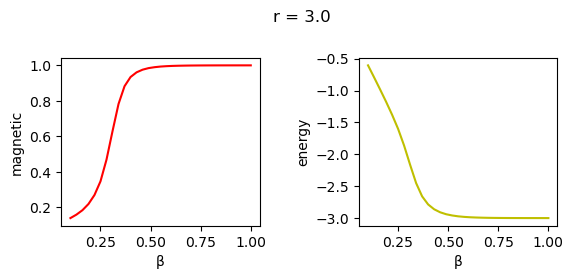

 11.552593 seconds (464.90 k allocations: 496.577 MiB, 0.35% gc time)


PyObject Text(309.97499999999997, 0.5, 'energy')

In [16]:
#test1
lattice = 8;               #晶格大小
Sweeps_heat = Int(1e4);       #热浴蒙卡次数
Sweeps = Int(1e6);           #蒙卡次数
βB = 0.1;                    #温度区间初始
βE = 1;                    #温度区间末尾
d = 0.03;                   #温度区间间隔
steps = Int(round((βE-βB)/d+1));
mag_ave = zeros(steps,1);
ene_ave = zeros(steps,1);
r = 3.0
@time begin
    Threads.@threads for i=1:steps
        β = βB+ d*(i-1);
        mag_ave[i], ene_ave[i] = MC(lattice,β,r,Sweeps_heat,Sweeps)
    end
end
β=βB:d:βE
subplots_adjust(wspace=0.5)
suptitle("r = $r")
subplot(221)
plot(β,mag_ave,"r")
xlabel("β")
ylabel("magnetic")

subplot(222)
plot(β,ene_ave,"y")
xlabel("β")
ylabel("energy")

Starting point has λL1 = 1.7363176214190643 ,λL2 =  1.736317621419052
                        λR1 = 1.736317621419075 ,λR2 =  1.7363176214190479
Step 1: 
                                    λ1 * λ2 = 4.752706108327306 + 2.6645352591003757e-15im,
                                    λL1 = 4.722593286751464,
                                    λL2 = 4.722593286751442, 
                                    err1 ≈ 0.066303395280962, 
                                    err2 ≈ 0.07355919284640189
Step 2: 
                                        λ1 * λ2 = 4.779582244406373 + 1.7486012637846216e-15im,
                                        λL1 = 4.7795821534220355,
                                        λL2 = 4.779582153422025, 
                                        err1 ≈ 0.0001211875844668754, 
                                        err2 ≈ 0.00012063806990003988


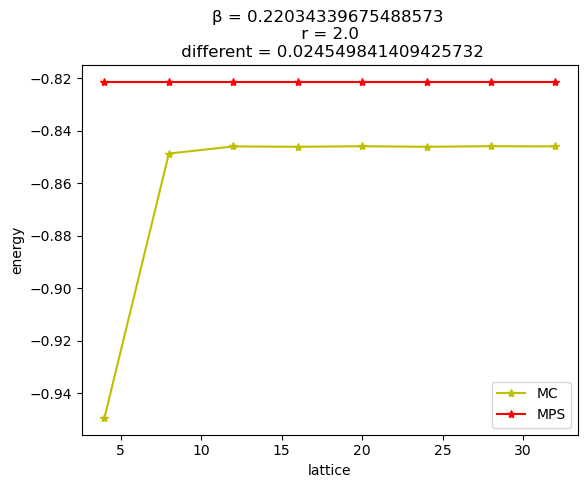

Step 3: 
                                        λ1 * λ2 = 4.779582265087997 + 5.995204332975845e-15im,
                                        λL1 = 4.779582265087952,
                                        λL2 = 4.779582265087971, 
                                        err1 ≈ 1.9655950915947922e-10, 
                                        err2 ≈ 1.85054768894206e-10


PyObject Text(0.5, 1.0, 'β = 0.22034339675488573 \n r = 2.0 \n different = 0.024549841409425732')

In [18]:
#test2
β= 0.5*βc
# β = 0.1
r = 2.0
lB = 4;                    
lE = 32;                    
ld = 4;                    
steps = Int(round((lE-lB)/ld+1));
eMC = zeros(steps,1)
Threads.@threads for i=1:steps
    lattice = lB+ ld*(i-1);
    _, eMC[i] = MC(lattice,β,r,Int(1e4),Int(1e6))
end

M1, M2, ME1, ME2 = classicalisingmpo(β; r = r)
D = 50
Random.seed!(12345)
A1 = randn(D, 2, D) + im*randn(D, 2, D)
Random.seed!(12345)
A2 = randn(D, 2, D) + im*randn(D, 2, D)
λ1, λ2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2 = 
    vumps(A1,A2,M1,M2;tol = 1e-6,maxiter = 100)
emps = energy(M1, M2, ME1, ME2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2)
different = abs(emps - eMC[steps])

lattice = lB:ld:lE
plot(lattice,eMC,"*-",color = "y",label = "MC")
plot(lattice,real(fill(emps,steps,1)),"*-",color = "r",label = "MPS")
legend(loc="best")
xlabel("lattice")
ylabel("energy")
title("β = $β \n r = $r \n different = $different")

### bond强度比例 r

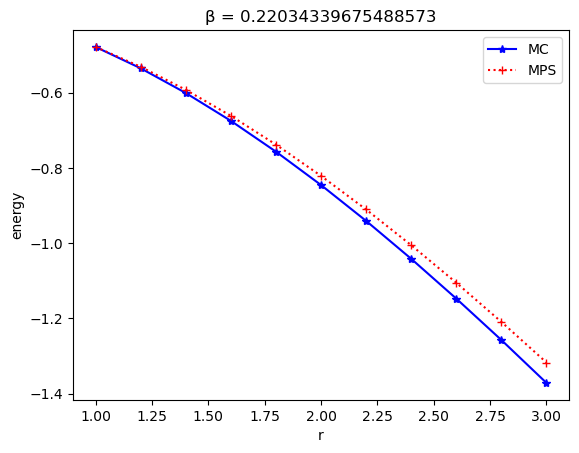

PyObject Text(0.5, 1.0, 'β = 0.22034339675488573')

In [19]:
#full test change r
βc = log(1+sqrt(2))/2
β = 0.5*βc
rB = 1;                    
rE = 3;                    
rd = 0.2;                    
steps = Int(round((rE-rB)/rd+1));
eMC = zeros(steps,1)
eMPS = zeros(steps,1)
lattice = 32
Threads.@threads for i=1:steps
    r = rB+ rd*(i-1);
    M1, M2, ME1, ME2 = classicalisingmpo(β; r = r)
    D = 50
    Random.seed!(12345)
    A1 = randn(D, 2, D) + im*randn(D, 2, D)
    Random.seed!(12345)
    A2 = randn(D, 2, D) + im*randn(D, 2, D)
    λ1, λ2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2 = 
        vumps(A1,A2,M1,M2;test = false, tol = 1e-6,maxiter = 100)
    eMPS[i] = real(energy(M1, M2, ME1, ME2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2))
    _, eMC[i] = MC(lattice,β,r,Int(1e4),Int(1e6))
end
r = rB:rd:rE
plot(r,eMC,"*-",color = "b",label = "MC")
plot(r,eMPS,"+:",color = "r",label = "MPS")
legend(loc="best")
xlabel("r")
ylabel("energy")
title("β = $β")

### 温度 β

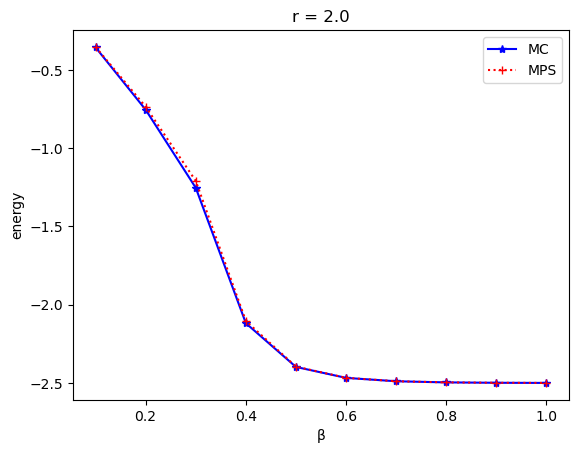

PyObject Text(0.5, 1.0, 'r = 2.0')

In [20]:
#full test change β
βc = log(1+sqrt(2))/2
βB = 0.1;                    
βE = 1;                    
βd = 0.1;  
r = 2.0
steps = Int(round((βE-βB)/βd+1));
eMC = zeros(steps,1)
eMPS = zeros(steps,1)
lattice = 32
Threads.@threads for i=1:steps
    β = βB+ βd*(i-1);
    M1, M2, ME1, ME2 = classicalisingmpo(β; r = r)
    D = 50
    Random.seed!(12345)
    A1 = randn(D, 2, D) + im*randn(D, 2, D)
    Random.seed!(12345)
    A2 = randn(D, 2, D) + im*randn(D, 2, D)
    λ1, λ2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2 = 
        vumps(A1,A2,M1,M2;test = false, tol = 1e-6,maxiter = 100)
    eMPS[i] = real(energy(M1, M2, ME1, ME2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2))
    _, eMC[i] = MC(lattice,β,r,Int(1e4),Int(1e6))
end
β = βB:βd:βE
plot(β,eMC,"*-",color = "b",label = "MC")
plot(β,eMPS,"+:",color = "r",label = "MPS")
legend(loc="best")
xlabel("β")
ylabel("energy")
title("r = $r")

## 待解决问题
### (√)快速迭代得到$L1，L2$时不收敛
由新的归一化条件，可以用之前的快速迭代方式
<img src="figure/18.png" width="100%">

### (√)r = 1.01~1.1之间时能量收敛
在临界点附近不容易收敛,可以尝试用低温向高温迭代

容易算的温度的确加快，临界点附近还是不收敛

r = 1.01
r = 1.04
r = 1.03
r = 1.09
r = 1.02
r = 1.08
r = 1.05
r = 1.06
r = 1.07
r = 1.1
e[i] = -1.218672650686904 - 4.0332320816460765e-17im
e[i] = -0.8310567864219534 - 1.3168719587008937e-15im
e[i] = -0.8441174347589089 + 2.4650854274499423e-14im
e[i] = -0.8084941365423747 - 5.4626442258509655e-15im
e[i] = -0.8726864513436559 - 1.6696713456276768e-17im
e[i] = -0.9439421870701652 - 4.2869353900076845e-16im
e[i] = -0.8312526322974662 + 1.4268100589909238e-15im
e[i] = -0.7852455608767427 - 1.317522480004385e-15im
e[i] = -0.7898543288747433 - 3.2650748424400966e-16im
e[i] = -0.8992705155969987 + 9.540979117872439e-17im


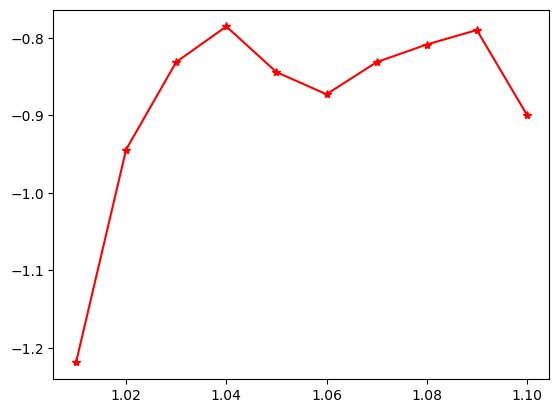

r = 1.01 ,energy = -1.218672650686904
r = 1.02 ,energy = -0.9439421870701652
r = 1.03 ,energy = -0.8310567864219534
r = 1.04 ,energy = -0.7852455608767427
r = 1.05 ,energy = -0.8441174347589089
r = 1.06 ,energy = -0.8726864513436559
r = 1.07 ,energy = -0.8312526322974662
r = 1.08 ,energy = -0.8084941365423747
r = 1.09 ,energy = -0.7898543288747433
r = 1.1 ,energy = -0.8992705155969987


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000051E4CDF0>

In [12]:
# r = 1.01~1.1
βc = log(1+sqrt(2))/2
β = 0.95*βc
e = zeros(10) + im * zeros(10)
Threads.@threads for i = 1:10
    r = 1.0 + 0.01 * i
    M1, M2, ME1, ME2 = classicalisingmpo(β; r = r)
    print("r = $r\n")
    D = 50
    Random.seed!(12345)
    A1 = randn(D, 2, D) + im*randn(D, 2, D)
    Random.seed!(12345)
    A2 = randn(D, 2, D) + im*randn(D, 2, D)
    λ1, λ2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2 = 
        vumps(A1,A2,M1,M2;test = false,tol = 1e-6,maxiter = 100)
    e[i] = energy(M1, M2, ME1, ME2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2)
    @show e[i]
end
x = 1.01:0.01:1.1
for i = 1:1:10
    r = 1.0 + 0.01 * i
    y = real(e[i])
    println("r = $r ,energy = $y")
end
plot(x, real(e),"*-", color = "red")

β = 0.4506867935097715
β = 0.4496867935097715
e[i] = -1.510557806337283 - 1.0299920638612292e-17im
β = 0.4486867935097715
e[i] = -1.5023807094564474 + 1.2630955309456127e-17im
β = 0.4476867935097715
e[i] = -1.4938950313868713 - 1.5695859325801087e-16im
β = 0.4466867935097715
e[i] = -1.485162817472196 + 7.649046326885234e-17im
β = 0.4456867935097715
e[i] = -1.4765904327959114 + 1.4060746924421386e-17im
β = 0.44468679350977147
e[i] = -1.4689444522551782 + 1.8173938916288268e-17im
β = 0.44368679350977147
e[i] = -1.4650549090301714 - 2.1510571102112408e-16im
β = 0.44268679350977147
e[i] = -0.8289070697133308 - 1.8533351936467213e-15im
β = 0.44168679350977147
e[i] = -0.910792899818398 - 1.2396333959330263e-14im
β = 0.44068679350977147
e[i] = 

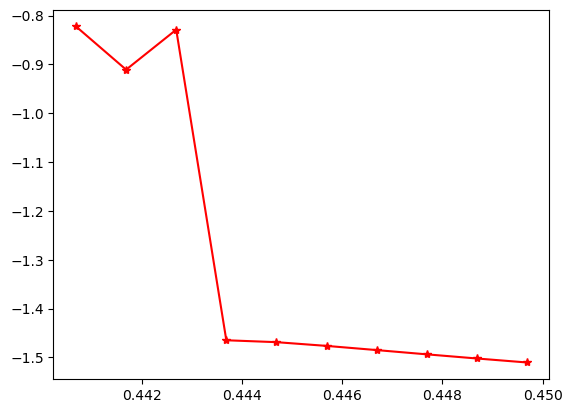

-0.8223522021931251 + 8.107663845846602e-16im
β = 0.4496867935097715 ,energy = -1.510557806337283
β = 0.4486867935097715 ,energy = -1.5023807094564474
β = 0.4476867935097715 ,energy = -1.4938950313868713
β = 0.4466867935097715 ,energy = -1.485162817472196
β = 0.4456867935097715 ,energy = -1.4765904327959114
β = 0.44468679350977147 ,energy = -1.4689444522551782
β = 0.44368679350977147 ,energy = -1.4650549090301714
β = 0.44268679350977147 ,energy = -0.8289070697133308
β = 0.44168679350977147 ,energy = -0.910792899818398
β = 0.44068679350977147 ,energy = -0.8223522021931251


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000006140F6A0>

In [17]:
# β = 0.5~1.5 r = 1.01
βc = log(1+sqrt(2))/2
e = zeros(10) + im * zeros(10)
β = βc + 0.01
M1, M2, ME1, ME2 = classicalisingmpo(β; r = 1.0)
print("β = $β\n")
D = 50
Random.seed!(12345)
A1 = randn(D, 2, D) + im*randn(D, 2, D)
Random.seed!(12345)
A2 = randn(D, 2, D) + im*randn(D, 2, D)
λ1, λ2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2 = 
    vumps(A1,A2,M1,M2;test = false, tol = 1e-6,maxiter = 100)
tol = 1e-6
maxiter = 100
for i = 1:10
    β =  βc + 0.001 * (10 - i)
    print("β = $β\n")
    M1, M2, ME1, ME2 = classicalisingmpo(β; r = 1.0)
    λ1, AL1, C1, AR1, errL1, errR1 = vumpsstep(AL1,C1,FL1,FL2,FR1,M1;tol = tol/10)
    λ2, AL2, C2, AR2, errL2, errR2 = vumpsstep(AL2,C2,FL2,FL1,FR2,M2;tol = tol/10)
#     AL1, AL2, C1, C2, numiter = leftorth(AR1, AR2, C1, C2) # regauge MPS: not really necessary
    FL1, FL2,λL1,λL2 = leftenv(AL1, AL2, M1, M2)
    FR1, FR2,λR1,λR2 = rightenv(AR1, AR2, M1, M2)
    err1 = erro(AL1,C1,FL1,FR1,M1)
    err2 = erro(AL2,C2,FL2,FR2,M2)
    j = 1
    while (err1 > tol || err2 > tol) && j < maxiter
        λ1, AL1, C1, AR1, errL1, errR1 = vumpsstep(AL1,C1,FL1,FL2,FR1,M1;tol = tol/10)
        λ2, AL2, C2, AR2, errL2, errR2 = vumpsstep(AL2,C2,FL2,FL1,FR2,M2;tol = tol/10)
        FL1, FL2,λL1,λL2 = leftenv(AL1, AL2, M1, M2)
        FR1, FR2,λR1,λR2 = rightenv(AR1, AR2, M1, M2)
#         FR1 ./= @tensor scalar(FL2[c,b,a]*C1[a,a']*conj(C1[c,c'])*FR1[a',b,c']) 
#         FR2 ./= @tensor scalar(FL1[c,b,a]*C2[a,a']*conj(C2[c,c'])*FR2[a',b,c']) # normalize FL and FR: not really necessary
        err1 = erro(AL1,C1,FL1,FR1,M1)
        err2 = erro(AL2,C2,FL2,FR2,M2)
        j += 1
        λ =  λ1 * λ2
    end
    e[i] = energy(M1, M2, ME1, ME2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FR1, FR2)
    @show e[i]
end
x = βc + 0.009 : -0.001 : βc
for i = 1:1:10
    β = βc + 0.001 * (10 - i)
    y = real(e[i])
    println("β = $β ,energy = $y")
end
plot(x, real(e),"*-", color = "red")

### (√)Z2(自由能)不为实数问题
来源于FLi和FRi未归一化:相当于未归一波函数，所以出现自由能非物理

ACi ,Ci -> ALi 的计算问题由新的归一化条件消除

### J1-J2计算能量不正确
需要4种不同能量张量，纵向能量需要不同的MPS
<img src="figure/19.png" width="50%">